In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchvision.transforms import v2
import numpy as np
# import PIL

In [2]:
torchvision.__version__

'0.16.0'

## Import data

In [3]:
folder="./dataset"
# transform = transforms.Compose([transforms.ToTensor()])
data_train_val=torchvision.datasets.FashionMNIST(root=folder,train=True,download=True,transform=None)
data_test=torchvision.datasets.FashionMNIST(root=folder,train=False,download=True,transform=None)
classes=data_test.classes

### 1. Data Preparation (10 points)
- (a) Data cleansing and transformation (5 points)

In [4]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, inputs, targets, trans=None):
        self.x = inputs
        self.y = targets
        self.trans=trans

    def __len__(self):
        return self.x.size()[0]

    def __getitem__(self, idx):

        if self.trans == None:
            # print("no trans")
            return ( self.x[idx], self.y[idx])
        else:
            # print("trans")
            return ( self.trans(self.x[idx]), self.y[idx]) 

def ds_trans(ds_input,trans_flag):
    data_input=ds_input.data.clone().detach()
    labels_input=ds_input.targets
    if data_input.ndim <= 3:
        transform_train_val = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((64, 64)), 
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomAffine(degrees=(0,3), translate=(0,0.05), scale=None, shear=(0,0.05)),
            transforms.RandomResizedCrop(size=(64,64),scale=(0.9,1.0),ratio=(0.9,1.1)),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5)
        ])
        transform_test = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((64, 64)), 
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5)
        ])
    elif data_input.ndim == 4:
        # Should not come here
        print("WRONG!")

    if torch.isnan(data_input).any():
        print("have NaN or Inf")
    data_input = data_input[:,None,:,:]
    print(data_input.shape)
    
    if trans_flag==1:
        flag_ds_new = dataset(data_input, labels_input, trans=transform_train_val)
    elif trans_flag==2:
        flag_ds_new = dataset(data_input, labels_input, trans=transform_test)
    else:
        flag_ds_new = dataset(data_input, labels_input, trans=None)
    return (flag_ds_new)
    

In [5]:
ds_processed_train_val=ds_trans(ds_input=data_train_val,trans_flag=1)
ds_processed_test=ds_trans(ds_input=data_test,trans_flag=2)
# ds_processed.x.shape

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


- (b) Data splitting (i.e., training, validation, and test splits) (5 points)

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler

random_seed=22
indices = list(range(data_train_val.targets.shape[0]))
np.random.seed(random_seed)
np.random.shuffle(indices)

indices_train=indices[:50000]
indices_val=indices[50000:]

ds_processed_train_sampler=SubsetRandomSampler(indices_train)
ds_processed_val_sampler=SubsetRandomSampler(indices_val)

# batch_size=64
batch_size=256
num_workers=10
loader_train = torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,sampler=ds_processed_train_sampler,
                                            num_workers=num_workers)
loader_val = torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,sampler=ds_processed_val_sampler,
                                            num_workers=num_workers)
loader_test = torch.utils.data.DataLoader(ds_processed_test, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

In [7]:
for batch_idx, (inputs, targets) in enumerate(loader_train):
    break
print(inputs.shape)
print(targets.shape)

torch.Size([256, 1, 64, 64])
torch.Size([256])


## 2. Exploratory Data Analysis (EDA) (10 points)
- (a) Descriptive statistics (e.g., class distributions, data statistics) (5 points)

- (b) Data visualization (e.g., plot examples from classes, dimensionality reduction approach to show data) (5 points)

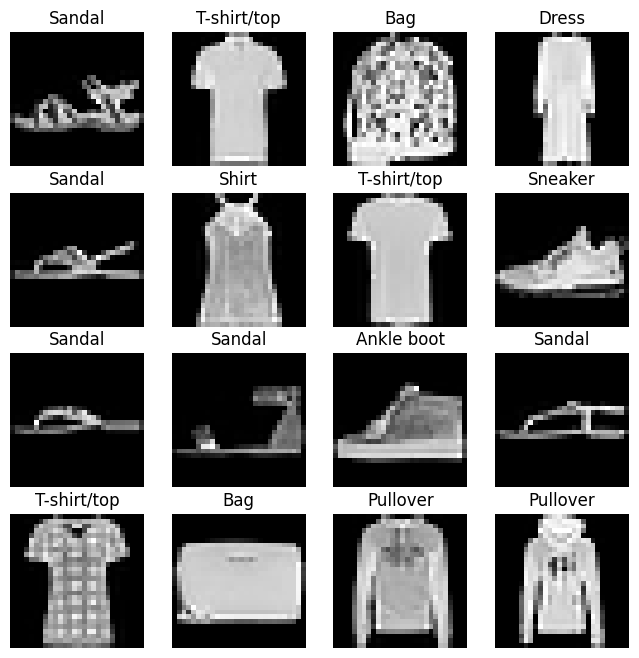

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize = (8,8))
cols, rows = 4, 4
ids=torch.randint(len(data_test), size = (cols*rows,))
for i in range (1, cols*rows + 1):
    image, label = data_test[ids[i-1].item()]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis('off')
    # plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(image, cmap='gray')
    # plt.imshow(image.squeeze())
plt.show()
classes

## 3. Model Selection (20 points)
- (a) Algorithm selection: Justification for choosing specific data mining algorithm (e.g., decision trees, KNN, neural networks, etc.). (5 points)

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def trainloop (dataloader, model, loss_fn, optimizer,device):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X,y=X.to(device),y.to(device)
        
        # Compute the error rate
        prediction = model(X)
        loss = loss_fn(prediction, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f'loss:{loss:>7f} [{current:>5d}/{size:>5d}]')
            
def evaluate (dataloader, model, loss_fn,device):
    # size = len(dataloader.dataset)
    size = len(dataloader.sampler)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    Y_pred=[]
    Y_true=[]
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            Y_pred.append(pred.argmax(1).cpu().numpy())
            Y_true.append(y.cpu().numpy())
    test_loss /= num_batches
    correct /= size
    print(f'Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')
    accuracy=100*correct
    Y_pred=np.concatenate(Y_pred)
    Y_true=np.concatenate(Y_true)
    accuracy2=accuracy_score(Y_true,Y_pred)
    # print(f'Accuracy2: {(accuracy2*100):>0.1f}')
    precision = precision_score(Y_true, Y_pred, average='macro')
    recall = recall_score(Y_true, Y_pred, average='macro')
    f1 = f1_score(Y_true, Y_pred, average='macro')
    cm = confusion_matrix(Y_true, Y_pred)
    print("accuracy, precision, recall, f1, test_loss:")
    print(accuracy, precision, recall, f1, test_loss)
    return [accuracy, precision, recall, f1, test_loss], cm

- (b) Model building: Developing and tuning selected model (e.g., hyperparameter tuning) (10 points)
- (c) Model evaluation: Proper evaluation metrics (e.g., accuracy, precision, recall, F1-score) and qualitative analysis (e.g., confusion matrices) for classification on test set. (5 points)

In [10]:
import torchvision
# define function for building, training, and testing the model.
def build_train_model(loader_train,loader_val,loader_test,learning_rate,id_optimizer):
    device ='cuda' if torch.cuda.is_available else 'cpu'
    print(f'Using {device} device')
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
    # model=torchvision.models.vgg11()
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', weights='DenseNet121_Weights.IMAGENET1K_V1')
    model=torchvision.models.squeezenet1_0(weights='SqueezeNet1_0_Weights.IMAGENET1K_V1')
    
    # model
    # model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) # vgg
    # model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)) # densenet121
    model.features[0]=torch.nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2)) # SqueezeNet

    model=model.to(device)
    # model

    # Define hyperparameters
    # learning_rate = 1e-4

    # Define epochs
    epochs = 10

    # Loss Function
    loss_fn = nn.CrossEntropyLoss()

    # Optimizer
    if id_optimizer==0:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif id_optimizer==1:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    elif id_optimizer==2:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    

    for i in range(epochs):
        print(f"Epoch {i+1}")
        # print(f"Epoch {i+1}\n-------------------------------")
        trainloop(loader_train, model, loss_fn, optimizer,device)

        if i%10==0:
            print("Training Dataset Error:")
            evaluate(loader_train, model, loss_fn,device)
            print("Validation Dataset Error:");
            evaluate(loader_val, model, loss_fn,device)
            print("Test Dataset Error:");
            evaluate(loader_test, model, loss_fn,device)

    print("Training Dataset Error:")
    result_train,cm_train=evaluate(loader_train, model, loss_fn,device)
    print("Validation Dataset Error:");
    result_val,cm_val=evaluate(loader_val, model, loss_fn,device)
    print("Test Dataset Error:");
    result_test,cm_test=evaluate(loader_test, model, loss_fn,device)

    results=[result_train,result_val,result_test]

    return results,cm_val

In [11]:
# define function for 6-fold cross validation to return training, validation, and testing dataset.
def split_6_fold(index,ds_processed_train_val,ds_processed_test,indices):
    N=ds_processed_train_val.y.shape[0]
    nsub=int(N/6)
    # indices_train=indices[:50000]
    indices_train=[indices[i] for i in range(N) if i <index*nsub or i >=(index+1)*nsub]
    indices_val=indices[index*nsub:(index+1)*nsub]

    ds_processed_train_sampler=SubsetRandomSampler(indices_train)
    ds_processed_val_sampler=SubsetRandomSampler(indices_val)

    # batch_size=64
    batch_size=256
    num_workers=6
    loader_train = torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,sampler=ds_processed_train_sampler,
                                                num_workers=num_workers)
    loader_val = torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,sampler=ds_processed_val_sampler,
                                                num_workers=num_workers)
    loader_test = torch.utils.data.DataLoader(ds_processed_test, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)
    return  loader_train,loader_val,loader_test

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# define function for cross validation with given hyperparameters or optimizer selection.
def one_iteration(learning_rate, id_optimizer,indices):
    # learning_rate=1e-4
    # id_optimizer=0
    ACC=[]
    LOSS=[]
    Results=[]
    CM_val=[]
    for i in range(6):
        print(f"Fold {i}\n-------------------------------")
        loader_train,loader_val,loader_test=split_6_fold(i,ds_processed_train_val,ds_processed_test,indices)
        results,cm_val=build_train_model(loader_train,loader_val,loader_test,learning_rate,id_optimizer)
        results=np.array(results)
        Results.append(results)
        CM_val.append(cm_val)
        torch.cuda.empty_cache() # test
    Results=np.array(Results) # dim0: i from 0-5; dim1: train, val, test; dim2: acc, precision, recall, f1 score, loss
    Results_ave=np.mean(Results,0) #dim0: train, val, test; dim1: acc, precision, recall, f1 score, loss
    try:
        CM_val_ave=np.mean(CM_val,0)
        CM_val_ave_percent=CM_val_ave/np.sum(CM_val_ave,
                                             axis=1,keepdims=True)

        print("Results_ave: \nacc, precision, recall, f1 score, loss")
        print(Results_ave)
        print("Confusion Matrix: \n",CM_val_ave_percent)
        classes_id=['0','1','2','3','4','5','6','7','8','9']
        # print(classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=np.round(CM_val_ave_percent,2),
                                display_labels=classes_id)
        disp.plot()
        plt.show()
    except:
        print("Failed to plot.")

    return Results_ave

id_optimizer: 0	learning_rate: 0.01 
-----------------------------------------------------------
Fold 0
-------------------------------
Using cuda device
Epoch 1
loss:18.871933 [    0/60000]
loss:2.293972 [25600/60000]
Training Dataset Error:
Accuracy: 28.5%, Avg loss: 2.021522 

accuracy, precision, recall, f1, test_loss:
28.546 0.2781539725942786 0.28578020037171076 0.22405399502815898 2.021522419793265
Validation Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 28.8%, Avg loss: 1.989041 

accuracy, precision, recall, f1, test_loss:
28.77 0.28487564378451324 0.2861608181520981 0.22431853834870985 1.9890407532453538
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 27.5%, Avg loss: 1.984391 

accuracy, precision, recall, f1, test_loss:
27.54 0.2784519766847498 0.2754 0.21294709395436073 1.984391063451767
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:2.028415 [    0/60000]
loss:1.045340 [25600/60000]
Epoch 3
loss:0.822427 [    0/60000]
loss:0.732349 [25600/60000]
Epoch 4
loss:0.601914 [    0/60000]
loss:0.810410 [25600/60000]
Epoch 5
loss:0.684972 [    0/60000]
loss:0.605546 [25600/60000]
Epoch 6
loss:0.626235 [    0/60000]
loss:0.716241 [25600/60000]
Epoch 7
loss:0.699995 [    0/60000]
loss:0.496243 [25600/60000]
Epoch 8
loss:0.513187 [    0/60000]
loss:0.665198 [25600/60000]
Epoch 9
loss:0.456434 [    0/60000]
loss:0.499462 [25600/60000]
Epoch 10
loss:0.571834 [    0/60000]
loss:0.420698 [25600/60000]
Training Dataset Error:
Accuracy: 81.2%, Avg loss: 0.493735 

accuracy, precision, recall, f1, test_loss:
81.242 0.824455794073059 0.8117282239472026 0.8116343758212275 0.4937346378455357
Validation Dataset Error:
Accuracy: 80.3%, Avg loss: 0.516491 

accuracy, precision, recall, f1, test_loss:
80.32000000000001 0.8194129478954852 0.8067714303648238 0.8064452499744359 0.5164911426603794
Test Dataset Error:
Accuracy: 82.0%, Avg 

/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 60.4%, Avg loss: 0.982394 

accuracy, precision, recall, f1, test_loss:
60.38 0.6137438060460214 0.6038 0.5814593824034311 0.9823942646384239
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:1.040255 [    0/60000]
loss:0.887765 [25600/60000]
Epoch 3
loss:0.768725 [    0/60000]
loss:0.687278 [25600/60000]
Epoch 4
loss:0.569045 [    0/60000]
loss:0.593935 [25600/60000]
Epoch 5
loss:0.629398 [    0/60000]
loss:2.366105 [25600/60000]
Epoch 6
loss:2.371408 [    0/60000]
loss:2.317457 [25600/60000]
Epoch 7
loss:2.325366 [    0/60000]
loss:2.319034 [25600/60000]
Epoch 8
loss:2.314142 [    0/60000]
loss:2.311705 [25600/60000]
Epoch 9
loss:2.315999 [    0/60000]
loss:2.303230 [25600/60000]
Epoch 10
loss:2.306046 [    0/60000]
loss:2.314570 [25600/60000]
Training Dataset Error:
Accuracy: 9.9%, Avg loss: 2.313371 

accuracy, precision, recall, f1, test_loss:
9.932 0.009932 0.1 0.018069351963031693 2.3133710051069456
Validation Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 10.3%, Avg loss: 2.313151 

accuracy, precision, recall, f1, test_loss:
10.34 0.01034 0.1 0.018742069965560996 2.3131510078907014
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 10.0%, Avg loss: 2.314996 

accuracy, precision, recall, f1, test_loss:
10.0 0.01 0.1 0.01818181818181818 2.3149964451789855
Results_ave: 
acc, precision, recall, f1 score, loss
[[69.95133333  0.684892    0.69972664  0.68169979  0.78237475]
 [69.76833333  0.68206403  0.69662464  0.67888569  0.78700023]
 [70.105       0.68787065  0.70105     0.68386248  0.77949639]]
Confusion Matrix: 
 [[8.68333333e-01 2.16666667e-03 1.06666667e-02 3.86666667e-02
  6.16666667e-03 2.66666667e-03 6.10000000e-02 0.00000000e+00
  1.03333333e-02 0.00000000e+00]
 [1.72833333e-01 7.97666667e-01 2.66666667e-03 1.93333333e-02
  2.50000000e-03 1.16666667e-03 3.16666667e-03 0.00000000e+00
  6.66666667e-04 0.00000000e+00]
 [1.73833333e-01 2.33333333e-03 5.54833333e-01 1.21666667e-02
  1.58833333e-01 2.50000000e-03 8.83333333e-02 0.00000000e+00
  7.16666667e-03 0.00000000e+00]
 [1.99000000e-01 1.01666667e-02 3.50000000e-03 7.25500000e-01
  4.18333333e-02 8.33333333e-04 1.63333333e-02 0.00000000e+00
  2.833

/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


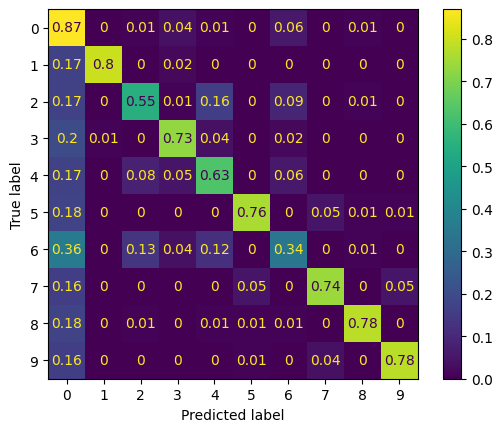

####################################################
id_optimizer: 0	learning_rate: 0.001 
-----------------------------------------------------------
Fold 0
-------------------------------
Using cuda device
Epoch 1
loss:17.496937 [    0/60000]
loss:0.786022 [25600/60000]
Training Dataset Error:
Accuracy: 76.8%, Avg loss: 0.588491 

accuracy, precision, recall, f1, test_loss:
76.84 0.7668218054938578 0.767137291772436 0.7596555894353549 0.5884912524904523
Validation Dataset Error:
Accuracy: 76.6%, Avg loss: 0.598201 

accuracy, precision, recall, f1, test_loss:
76.58 0.7715403052167126 0.7720916192297672 0.7638002249835515 0.5982009023427963
Test Dataset Error:
Accuracy: 77.9%, Avg loss: 0.564498 

accuracy, precision, recall, f1, test_loss:
77.86 0.7750587953778937 0.7786 0.770079913244506 0.5644975155591965
Epoch 2
loss:0.780864 [    0/60000]
loss:0.703480 [25600/60000]
Epoch 3
loss:0.581161 [    0/60000]
loss:0.521084 [25600/60000]
Epoch 4
loss:0.435019 [    0/60000]
loss:0.365984 [

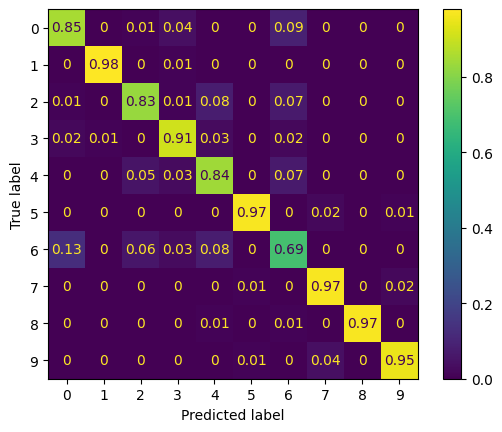

####################################################
id_optimizer: 0	learning_rate: 0.0001 
-----------------------------------------------------------
Fold 0
-------------------------------
Using cuda device
Epoch 1
loss:15.611699 [    0/60000]
loss:0.924586 [25600/60000]
Training Dataset Error:
Accuracy: 77.9%, Avg loss: 0.592698 

accuracy, precision, recall, f1, test_loss:
77.936 0.7733977542878816 0.7782914086780823 0.7736589057535457 0.5926978851155359
Validation Dataset Error:
Accuracy: 77.6%, Avg loss: 0.603628 

accuracy, precision, recall, f1, test_loss:
77.56 0.7743824941622902 0.7810260514835 0.7753800876467061 0.6036283016204834
Test Dataset Error:
Accuracy: 77.9%, Avg loss: 0.586837 

accuracy, precision, recall, f1, test_loss:
77.92999999999999 0.772809041322292 0.7793 0.7722019618666784 0.5868371970951557
Epoch 2
loss:0.784272 [    0/60000]
loss:0.599966 [25600/60000]
Epoch 3
loss:0.658721 [    0/60000]
loss:0.594448 [25600/60000]
Epoch 4
loss:0.537738 [    0/60000]
los

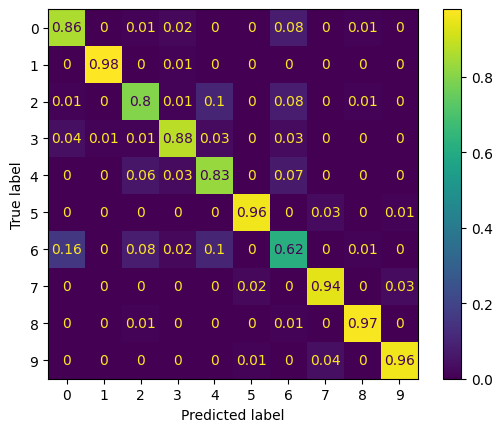

####################################################
id_optimizer: 1	learning_rate: 0.01 
-----------------------------------------------------------
Fold 0
-------------------------------
Using cuda device
Epoch 1
loss:14.960421 [    0/60000]
loss:2.329438 [25600/60000]
Training Dataset Error:
Accuracy: 10.0%, Avg loss: 2.348195 

accuracy, precision, recall, f1, test_loss:
10.024 0.010024 0.1 0.018221478950047262 2.3481954457808514
Validation Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 9.9%, Avg loss: 2.354387 

accuracy, precision, recall, f1, test_loss:
9.879999999999999 0.00988 0.1 0.017983254459410267 2.354387402534485
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 10.0%, Avg loss: 2.347691 

accuracy, precision, recall, f1, test_loss:
10.0 0.01 0.1 0.01818181818181818 2.3476913928985597
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:2.364228 [    0/60000]
loss:2.319755 [25600/60000]
Epoch 3
loss:2.448491 [    0/60000]
loss:2.348855 [25600/60000]
Epoch 4
loss:2.397235 [    0/60000]
loss:2.316840 [25600/60000]
Epoch 5
loss:2.349823 [    0/60000]
loss:2.317772 [25600/60000]
Epoch 6
loss:2.313315 [    0/60000]
loss:2.364897 [25600/60000]
Epoch 7
loss:2.363843 [    0/60000]
loss:2.316684 [25600/60000]
Epoch 8
loss:2.331460 [    0/60000]
loss:2.329545 [25600/60000]
Epoch 9
loss:2.369153 [    0/60000]
loss:2.321200 [25600/60000]
Epoch 10
loss:2.319146 [    0/60000]
loss:2.326735 [25600/60000]
Training Dataset Error:
Accuracy: 9.9%, Avg loss: 2.333975 

accuracy, precision, recall, f1, test_loss:
9.856 0.009856 0.1 0.017943489659190213 2.3339748139284096
Validation Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 10.7%, Avg loss: 2.330730 

accuracy, precision, recall, f1, test_loss:
10.72 0.01072 0.1 0.019364161849710983 2.3307300448417663
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 10.0%, Avg loss: 2.331805 

accuracy, precision, recall, f1, test_loss:
10.0 0.01 0.1 0.01818181818181818 2.3318047165870666
Fold 1
-------------------------------
Using cuda device
Epoch 1


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:16.493959 [    0/60000]
loss:2.091273 [25600/60000]
Training Dataset Error:
Accuracy: 39.9%, Avg loss: 1.485232 

accuracy, precision, recall, f1, test_loss:
39.932 0.4368872911818273 0.4004796008105117 0.322653051525133 1.4852324858003734
Validation Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 40.7%, Avg loss: 1.483742 

accuracy, precision, recall, f1, test_loss:
40.660000000000004 0.4966118442884519 0.4007716965429385 0.3263265859893229 1.4837422668933868
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 40.9%, Avg loss: 1.472408 

accuracy, precision, recall, f1, test_loss:
40.92 0.41425316835875964 0.40920000000000006 0.3257028525750758 1.4724075108766557
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:1.639802 [    0/60000]
loss:2.339056 [25600/60000]
Epoch 3
loss:1.373722 [    0/60000]
loss:1.377927 [25600/60000]
Epoch 4
loss:1.175901 [    0/60000]
loss:1.070691 [25600/60000]
Epoch 5
loss:1.814224 [    0/60000]
loss:0.870028 [25600/60000]
Epoch 6
loss:1.062172 [    0/60000]
loss:0.899881 [25600/60000]
Epoch 7
loss:0.880011 [    0/60000]
loss:1.494583 [25600/60000]
Epoch 8
loss:1.218703 [    0/60000]
loss:1.075890 [25600/60000]
Epoch 9
loss:1.265428 [    0/60000]
loss:0.895639 [25600/60000]
Epoch 10
loss:1.442562 [    0/60000]
loss:1.094800 [25600/60000]
Training Dataset Error:
Accuracy: 68.2%, Avg loss: 0.852495 

accuracy, precision, recall, f1, test_loss:
68.16 0.6844730764226113 0.6824589342625383 0.6606318308384347 0.8524945956103656
Validation Dataset Error:
Accuracy: 69.1%, Avg loss: 0.841221 

accuracy, precision, recall, f1, test_loss:
69.06 0.6897357220887245 0.6862591397209876 0.6661493640068081 0.8412210866808891
Test Dataset Error:
Accuracy: 68.6%, Avg loss: 0.8321

/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 9.8%, Avg loss: 2.333423 

accuracy, precision, recall, f1, test_loss:
9.85 0.009850000000000001 0.1 0.017933545744196634 2.3334227919578554
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 10.0%, Avg loss: 2.329920 

accuracy, precision, recall, f1, test_loss:
10.0 0.01 0.1 0.01818181818181818 2.3299197256565094
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:2.358787 [    0/60000]
loss:2.328841 [25600/60000]
Epoch 3
loss:2.351952 [    0/60000]
loss:2.342746 [25600/60000]
Epoch 4
loss:2.411278 [    0/60000]
loss:2.317764 [25600/60000]
Epoch 5
loss:2.378704 [    0/60000]
loss:2.325775 [25600/60000]
Epoch 6
loss:2.361547 [    0/60000]
loss:2.316500 [25600/60000]
Epoch 7
loss:2.327898 [    0/60000]
loss:2.324625 [25600/60000]
Epoch 8
loss:2.354223 [    0/60000]
loss:2.304016 [25600/60000]
Epoch 9
loss:2.308553 [    0/60000]
loss:2.317697 [25600/60000]
Epoch 10
loss:2.354300 [    0/60000]
loss:2.317523 [25600/60000]
Training Dataset Error:
Accuracy: 9.9%, Avg loss: 2.322708 

accuracy, precision, recall, f1, test_loss:
9.898 0.009898 0.1 0.01801306666181368 2.3227078695686494
Validation Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 10.5%, Avg loss: 2.321476 

accuracy, precision, recall, f1, test_loss:
10.51 0.01051 0.1 0.019020903085693604 2.3214761674404145
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 10.0%, Avg loss: 2.321955 

accuracy, precision, recall, f1, test_loss:
10.0 0.01 0.1 0.01818181818181818 2.321955460309982
Fold 3
-------------------------------
Using cuda device
Epoch 1


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:19.156471 [    0/60000]
loss:2.320792 [25600/60000]
Training Dataset Error:
Accuracy: 10.0%, Avg loss: 2.362321 

accuracy, precision, recall, f1, test_loss:
9.98 0.00998 0.1 0.018148754318967085 2.3623214692485575
Validation Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 10.1%, Avg loss: 2.358827 

accuracy, precision, recall, f1, test_loss:
10.100000000000001 0.010100000000000001 0.1 0.01834695731153497 2.358826720714569
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 10.0%, Avg loss: 2.361341 

accuracy, precision, recall, f1, test_loss:
10.0 0.01 0.1 0.01818181818181818 2.3613407909870148
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:2.371923 [    0/60000]
loss:2.342799 [25600/60000]
Epoch 3
loss:2.357357 [    0/60000]
loss:2.353519 [25600/60000]
Epoch 4
loss:2.346360 [    0/60000]
loss:2.340472 [25600/60000]
Epoch 5
loss:2.382057 [    0/60000]
loss:2.322942 [25600/60000]
Epoch 6
loss:2.321466 [    0/60000]
loss:2.329079 [25600/60000]
Epoch 7
loss:2.335783 [    0/60000]
loss:2.326905 [25600/60000]
Epoch 8
loss:2.335291 [    0/60000]
loss:2.305228 [25600/60000]
Epoch 9
loss:2.326741 [    0/60000]
loss:2.311944 [25600/60000]
Epoch 10
loss:2.328298 [    0/60000]
loss:2.339337 [25600/60000]
Training Dataset Error:
Accuracy: 9.9%, Avg loss: 2.322304 

accuracy, precision, recall, f1, test_loss:
9.89 0.00989 0.1 0.017999817999818 2.3223042329963373
Validation Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 10.5%, Avg loss: 2.317293 

accuracy, precision, recall, f1, test_loss:
10.549999999999999 0.01055 0.1 0.019086386250565357 2.3172926008701324
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 10.0%, Avg loss: 2.320152 

accuracy, precision, recall, f1, test_loss:
10.0 0.01 0.1 0.01818181818181818 2.3201520323753355
Fold 4
-------------------------------
Using cuda device
Epoch 1


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:14.316345 [    0/60000]
loss:2.555731 [25600/60000]
Training Dataset Error:
Accuracy: 27.8%, Avg loss: 2.165992 

accuracy, precision, recall, f1, test_loss:
27.798000000000002 0.2158362523454258 0.277429482271035 0.1879983040221315 2.1659916760970135
Validation Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 27.4%, Avg loss: 2.168943 

accuracy, precision, recall, f1, test_loss:
27.38 0.20342522533082094 0.27654616179394226 0.18312405355987368 2.1689426600933075
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 23.5%, Avg loss: 2.206617 

accuracy, precision, recall, f1, test_loss:
23.52 0.18613969540462508 0.23519999999999994 0.12928271514705927 2.2066174775362013
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:2.186099 [    0/60000]
loss:1.201382 [25600/60000]
Epoch 3
loss:1.346025 [    0/60000]
loss:0.887159 [25600/60000]
Epoch 4
loss:2.319726 [    0/60000]
loss:1.119923 [25600/60000]
Epoch 5
loss:1.026756 [    0/60000]
loss:0.667525 [25600/60000]
Epoch 6
loss:0.883115 [    0/60000]
loss:2.928281 [25600/60000]
Epoch 7
loss:0.988136 [    0/60000]
loss:0.697878 [25600/60000]
Epoch 8
loss:0.814420 [    0/60000]
loss:0.804195 [25600/60000]
Epoch 9
loss:0.801609 [    0/60000]
loss:2.165961 [25600/60000]
Epoch 10
loss:1.718618 [    0/60000]
loss:1.492316 [25600/60000]
Training Dataset Error:
Accuracy: 43.8%, Avg loss: 1.422164 

accuracy, precision, recall, f1, test_loss:
43.796 0.45014985284222525 0.43769529594692547 0.4053188844558974 1.4221637315896092
Validation Dataset Error:
Accuracy: 43.4%, Avg loss: 1.436645 

accuracy, precision, recall, f1, test_loss:
43.4 0.4480734701792127 0.43539814120774495 0.4011648931967846 1.436645257472992
Test Dataset Error:
Accuracy: 41.9%, Avg loss: 1.44

/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 10.5%, Avg loss: 2.364489 

accuracy, precision, recall, f1, test_loss:
10.549999999999999 0.026869513952574347 0.10725214734680591 0.03514999190017143 2.364488786458969
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 10.9%, Avg loss: 2.363326 

accuracy, precision, recall, f1, test_loss:
10.92 0.02733443000053496 0.1092 0.036052318002358294 2.3633263409137726
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:2.333248 [    0/60000]
loss:2.340985 [25600/60000]
Epoch 3
loss:2.320858 [    0/60000]
loss:2.326489 [25600/60000]
Epoch 4
loss:2.405199 [    0/60000]
loss:2.386183 [25600/60000]
Epoch 5
loss:2.368925 [    0/60000]
loss:2.310476 [25600/60000]
Epoch 6
loss:2.359257 [    0/60000]
loss:2.318218 [25600/60000]
Epoch 7
loss:2.358055 [    0/60000]
loss:2.368431 [25600/60000]
Epoch 8
loss:2.408855 [    0/60000]
loss:2.326787 [25600/60000]
Epoch 9
loss:2.312951 [    0/60000]
loss:2.316975 [25600/60000]
Epoch 10
loss:2.364816 [    0/60000]
loss:2.337982 [25600/60000]
Training Dataset Error:
Accuracy: 10.1%, Avg loss: 2.350052 

accuracy, precision, recall, f1, test_loss:
10.056 0.010055999999999999 0.1 0.018274333066802352 2.3500522241300468
Validation Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 9.7%, Avg loss: 2.354974 

accuracy, precision, recall, f1, test_loss:
9.719999999999999 0.00972 0.1 0.017717827196500183 2.354974228143692
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 10.0%, Avg loss: 2.353098 

accuracy, precision, recall, f1, test_loss:
10.0 0.01 0.1 0.01818181818181818 2.3530976355075834
Results_ave: 
acc, precision, recall, f1 score, loss
[[25.276       0.19572049  0.25335904  0.1896969   1.93394958]
 [25.66        0.19655153  0.25360955  0.19041726  1.93372323]
 [25.08666667  0.19231675  0.25086667  0.18703445  1.93464448]]
Confusion Matrix: 
 [[2.46333333e-01 2.16666667e-02 1.05000000e-02 1.86166667e-01
  1.76666667e-01 4.00000000e-03 1.77166667e-01 3.33333333e-04
  3.50000000e-03 1.73666667e-01]
 [1.16666667e-03 3.01833333e-01 4.00000000e-03 1.80833333e-01
  1.73500000e-01 1.66666667e-04 1.67000000e-01 0.00000000e+00
  3.33333333e-04 1.71166667e-01]
 [5.66666667e-03 7.33333333e-03 1.97166667e-01 1.67666667e-01
  2.34333333e-01 4.83333333e-03 2.12333333e-01 0.00000000e+00
  3.16666667e-03 1.67500000e-01]
 [1.46666667e-02 1.50500000e-01 3.83333333e-03 3.17666667e-01
  1.74500000e-01 1.50000000e-03 1.73333333e-01 0.00000000e+00
  3.333

/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


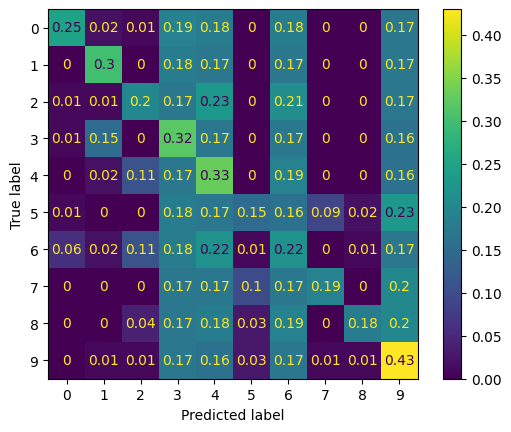

####################################################
id_optimizer: 1	learning_rate: 0.001 
-----------------------------------------------------------
Fold 0
-------------------------------
Using cuda device
Epoch 1
loss:22.870411 [    0/60000]
loss:2.013841 [25600/60000]
Training Dataset Error:
Accuracy: 53.0%, Avg loss: 1.216656 

accuracy, precision, recall, f1, test_loss:
53.03 0.5977232823677476 0.5293987874176775 0.48065354298848595 1.2166561532993705
Validation Dataset Error:
Accuracy: 52.8%, Avg loss: 1.216694 

accuracy, precision, recall, f1, test_loss:
52.83 0.5939923808441578 0.5332262188401815 0.4845577939494312 1.2166938364505768
Test Dataset Error:
Accuracy: 54.5%, Avg loss: 1.164872 

accuracy, precision, recall, f1, test_loss:
54.510000000000005 0.6455679107807846 0.5450999999999999 0.492953668523327 1.1648721247911453
Epoch 2
loss:1.363984 [    0/60000]
loss:0.871270 [25600/60000]
Epoch 3
loss:0.810955 [    0/60000]
loss:0.568445 [25600/60000]
Epoch 4
loss:2.692945 [ 

/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 29.6%, Avg loss: 1.739987 

accuracy, precision, recall, f1, test_loss:
29.580000000000002 0.1555856876782969 0.29378900066870167 0.1863267747096284 1.7399865537881851
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 29.8%, Avg loss: 1.701412 

accuracy, precision, recall, f1, test_loss:
29.759999999999998 0.15540560486206983 0.2976 0.18711935785725098 1.7014120131731034
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:1.780329 [    0/60000]
loss:1.027199 [25600/60000]
Epoch 3
loss:1.105691 [    0/60000]
loss:0.785715 [25600/60000]
Epoch 4
loss:2.020236 [    0/60000]
loss:0.633758 [25600/60000]
Epoch 5
loss:0.604044 [    0/60000]
loss:0.564091 [25600/60000]
Epoch 6
loss:0.591706 [    0/60000]
loss:0.495093 [25600/60000]
Epoch 7
loss:1.511451 [    0/60000]
loss:0.451541 [25600/60000]
Epoch 8
loss:0.583528 [    0/60000]
loss:0.490970 [25600/60000]
Epoch 9
loss:0.498923 [    0/60000]
loss:0.459120 [25600/60000]
Epoch 10
loss:0.397113 [    0/60000]
loss:0.367486 [25600/60000]
Training Dataset Error:
Accuracy: 85.7%, Avg loss: 0.407634 

accuracy, precision, recall, f1, test_loss:
85.694 0.872008956559073 0.8576044694768262 0.8461744854305616 0.40763374592880813
Validation Dataset Error:
Accuracy: 85.6%, Avg loss: 0.430459 

accuracy, precision, recall, f1, test_loss:
85.61 0.8690245557296981 0.8526172650381445 0.8416789900324829 0.4304585948586464
Test Dataset Error:
Accuracy: 86.2%, Avg loss: 0.397

/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 16.9%, Avg loss: 2.445240 

accuracy, precision, recall, f1, test_loss:
16.939999999999998 0.03388733011192473 0.16836164940718876 0.05640286319263711 2.4452400624752046
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 15.8%, Avg loss: 2.440632 

accuracy, precision, recall, f1, test_loss:
15.770000000000001 0.0315657443642824 0.1577 0.05257960692173318 2.4406323611736296
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:2.540376 [    0/60000]
loss:1.274310 [25600/60000]
Epoch 3
loss:1.289770 [    0/60000]
loss:3.454734 [25600/60000]
Epoch 4
loss:0.788280 [    0/60000]
loss:1.256376 [25600/60000]
Epoch 5
loss:0.697117 [    0/60000]
loss:0.562156 [25600/60000]
Epoch 6
loss:0.686227 [    0/60000]
loss:0.604025 [25600/60000]
Epoch 7
loss:0.480309 [    0/60000]
loss:0.434390 [25600/60000]
Epoch 8
loss:0.555165 [    0/60000]
loss:0.469199 [25600/60000]
Epoch 9
loss:0.447034 [    0/60000]
loss:0.427918 [25600/60000]
Epoch 10
loss:0.535269 [    0/60000]
loss:0.463063 [25600/60000]
Training Dataset Error:
Accuracy: 85.3%, Avg loss: 0.378533 

accuracy, precision, recall, f1, test_loss:
85.286 0.8628271110518012 0.8534138369432533 0.8505400876273826 0.37853294170024443
Validation Dataset Error:
Accuracy: 85.4%, Avg loss: 0.388136 

accuracy, precision, recall, f1, test_loss:
85.44 0.862497042030675 0.8517741061548803 0.8495157999466784 0.38813556879758837
Test Dataset Error:
Accuracy: 85.1%, Avg loss: 0.39

/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 26.9%, Avg loss: 1.895165 

accuracy, precision, recall, f1, test_loss:
26.900000000000002 0.3062216419815509 0.27327130378677555 0.21278825958594766 1.8951653748750688
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 30.4%, Avg loss: 1.814132 

accuracy, precision, recall, f1, test_loss:
30.42 0.3650750816402397 0.30419999999999997 0.24057425479039934 1.8141316145658493
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:2.049410 [    0/60000]
loss:0.882764 [25600/60000]
Epoch 3
loss:0.963232 [    0/60000]
loss:1.592840 [25600/60000]
Epoch 4
loss:1.576351 [    0/60000]
loss:0.714817 [25600/60000]
Epoch 5
loss:0.606163 [    0/60000]
loss:0.488983 [25600/60000]
Epoch 6
loss:0.538466 [    0/60000]
loss:0.525239 [25600/60000]
Epoch 7
loss:0.713224 [    0/60000]
loss:0.535969 [25600/60000]
Epoch 8
loss:1.017154 [    0/60000]
loss:0.464972 [25600/60000]
Epoch 9
loss:0.479915 [    0/60000]
loss:0.586049 [25600/60000]
Epoch 10
loss:0.458215 [    0/60000]
loss:0.400215 [25600/60000]
Training Dataset Error:
Accuracy: 85.5%, Avg loss: 0.384194 

accuracy, precision, recall, f1, test_loss:
85.49799999999999 0.8576220807370213 0.8547297652296907 0.8545531622553479 0.38419400353212746
Validation Dataset Error:
Accuracy: 84.7%, Avg loss: 0.416174 

accuracy, precision, recall, f1, test_loss:
84.68 0.8519029799384666 0.8480762838186793 0.8479339436577848 0.41617442294955254
Test Dataset Error:
Accuracy: 85.9%, Av

/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 21.6%, Avg loss: 2.270000 

accuracy, precision, recall, f1, test_loss:
21.62 0.3167382653385133 0.21778901142318188 0.13929820996500464 2.2700002998113633
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 23.1%, Avg loss: 2.142399 

accuracy, precision, recall, f1, test_loss:
23.13 0.2962833603844755 0.2313 0.15605469649773154 2.1423988550901414
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:2.274379 [    0/60000]
loss:2.544005 [25600/60000]
Epoch 3
loss:0.769374 [    0/60000]
loss:2.072652 [25600/60000]
Epoch 4
loss:0.827697 [    0/60000]
loss:0.981441 [25600/60000]
Epoch 5
loss:0.764717 [    0/60000]
loss:0.587630 [25600/60000]
Epoch 6
loss:0.661420 [    0/60000]
loss:0.598270 [25600/60000]
Epoch 7
loss:0.682943 [    0/60000]
loss:0.359609 [25600/60000]
Epoch 8
loss:0.673295 [    0/60000]
loss:0.452293 [25600/60000]
Epoch 9
loss:0.517103 [    0/60000]
loss:0.373515 [25600/60000]
Epoch 10
loss:0.547489 [    0/60000]
loss:0.355402 [25600/60000]
Training Dataset Error:
Accuracy: 77.6%, Avg loss: 0.606545 

accuracy, precision, recall, f1, test_loss:
77.568 0.8151863217166302 0.7758800060162185 0.7605381485788568 0.6065454928546535
Validation Dataset Error:
Accuracy: 77.8%, Avg loss: 0.597057 

accuracy, precision, recall, f1, test_loss:
77.75 0.8171308771258969 0.7764807429375757 0.7627306648806216 0.5970573894679546
Test Dataset Error:
Accuracy: 77.5%, Avg loss: 0.613

/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 52.3%, Avg loss: 1.295491 

accuracy, precision, recall, f1, test_loss:
52.28 0.5615240180903046 0.5218181907731717 0.4997209666317876 1.2954909175634384
Test Dataset Error:


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 52.3%, Avg loss: 1.282753 

accuracy, precision, recall, f1, test_loss:
52.32 0.5539170151881908 0.5232 0.5022593925032252 1.2827528268098831
Epoch 2


/home/percool/anaconda3/envs/fashion/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss:1.322626 [    0/60000]
loss:0.839801 [25600/60000]
Epoch 3
loss:1.110691 [    0/60000]
loss:1.696095 [25600/60000]
Epoch 4
loss:0.721629 [    0/60000]
loss:0.834390 [25600/60000]
Epoch 5
loss:0.650580 [    0/60000]
loss:0.573550 [25600/60000]
Epoch 6
loss:0.496341 [    0/60000]
loss:0.511781 [25600/60000]
Epoch 7
loss:0.433284 [    0/60000]
loss:0.514622 [25600/60000]
Epoch 8
loss:0.721559 [    0/60000]
loss:0.475688 [25600/60000]
Epoch 9
loss:0.400377 [    0/60000]
loss:0.399987 [25600/60000]
Epoch 10
loss:0.602652 [    0/60000]
loss:0.340183 [25600/60000]
Training Dataset Error:
Accuracy: 81.9%, Avg loss: 0.498106 

accuracy, precision, recall, f1, test_loss:
81.868 0.8352760463852855 0.8186711698607236 0.8046188975662414 0.498106488919988
Validation Dataset Error:
Accuracy: 81.4%, Avg loss: 0.503581 

accuracy, precision, recall, f1, test_loss:
81.38 0.8241874614564922 0.8137775781454124 0.7972288196405624 0.5035814568400383
Test Dataset Error:
Accuracy: 81.5%, Avg loss: 0.5121

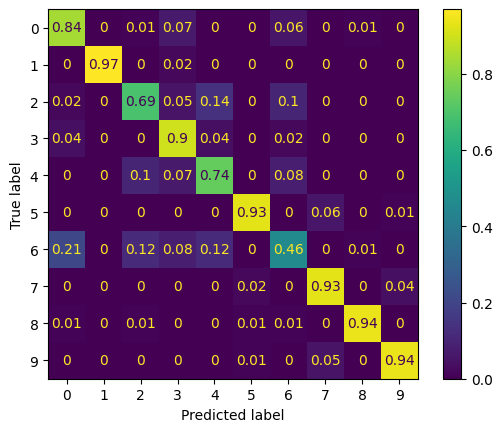

####################################################
id_optimizer: 1	learning_rate: 0.0001 
-----------------------------------------------------------
Fold 0
-------------------------------
Using cuda device
Epoch 1
loss:17.943670 [    0/60000]
loss:0.770596 [25600/60000]
Training Dataset Error:
Accuracy: 75.6%, Avg loss: 0.648634 

accuracy, precision, recall, f1, test_loss:
75.596 0.7777413506070361 0.7544628765936776 0.7346536163266422 0.6486335933512571
Validation Dataset Error:
Accuracy: 74.1%, Avg loss: 0.662997 

accuracy, precision, recall, f1, test_loss:
74.14 0.7678804311432987 0.7491927834672217 0.7268381274307106 0.6629972249269486
Test Dataset Error:
Accuracy: 76.1%, Avg loss: 0.631603 

accuracy, precision, recall, f1, test_loss:
76.09 0.7802153104834073 0.7609000000000001 0.7402056848908931 0.6316034197807312
Epoch 2
loss:0.805756 [    0/60000]
loss:0.631360 [25600/60000]
Epoch 3
loss:0.711980 [    0/60000]
loss:0.468543 [25600/60000]
Epoch 4
loss:0.561794 [    0/60000]

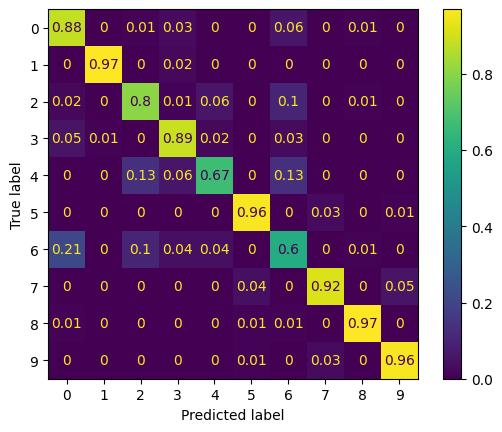

####################################################


In [13]:
# Use 6-fold validation to search best learning rate and optimizer.
random_seed=22
indices = list(range(ds_processed_train_val.y.shape[0]))
np.random.seed(random_seed)
np.random.shuffle(indices)
Results_all=[]
for id_optimizer in [0,1]:
    for learning_rate in [1e-2,1e-3,1e-4]:
    
        print(f"id_optimizer: {id_optimizer}\tlearning_rate: {learning_rate} \n-----------------------------------------------------------")
        Results_ave= one_iteration(learning_rate,id_optimizer,indices)
        Results_all.append([id_optimizer, learning_rate, Results_ave])
        print('####################################################')


In [14]:
Results_all

[[0,
  0.01,
  array([[69.95133333,  0.684892  ,  0.69972664,  0.68169979,  0.78237475],
         [69.76833333,  0.68206403,  0.69662464,  0.67888569,  0.78700023],
         [70.105     ,  0.68787065,  0.70105   ,  0.68386248,  0.77949639]])],
 [0,
  0.001,
  array([[90.13266667,  0.90444926,  0.9013184 ,  0.90082288,  0.26440525],
         [89.47166667,  0.89848809,  0.89477994,  0.89445055,  0.28694663],
         [89.41833333,  0.89777667,  0.89418333,  0.89336568,  0.2892826 ]])],
 [0,
  0.0001,
  array([[88.61766667,  0.88698272,  0.88619549,  0.88529876,  0.3054255 ],
         [87.94833333,  0.88004569,  0.87942044,  0.87851602,  0.32519636],
         [88.23166667,  0.88384514,  0.88231667,  0.88115975,  0.32497498]])],
 [1,
  0.01,
  array([[25.276     ,  0.19572049,  0.25335904,  0.1896969 ,  1.93394958],
         [25.66      ,  0.19655153,  0.25360955,  0.19041726,  1.93372323],
         [25.08666667,  0.19231675,  0.25086667,  0.18703445,  1.93464448]])],
 [1,
  0.001,
  array

## Retrain model with the best learning rate and optimizer
We retrain the model because in the cross validation we don't use the validation dataset for training. For the purpose of the best usage of dataset, we use all 60000 dataset in previous training and validation to train the model, and then estimate the final performance on the testing dataset.

In [15]:
def build_train_best_model(loader_train,loader_test,learning_rate,id_optimizer):
    device ='cuda' if torch.cuda.is_available else 'cpu'
    print(f'Using {device} device')

    # You can try different if necessary
    
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
    # model=torchvision.models.vgg11()
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', weights='DenseNet121_Weights.IMAGENET1K_V1')
    model=torchvision.models.squeezenet1_0(weights='SqueezeNet1_0_Weights.IMAGENET1K_V1')
    
    # model
    # model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) # vgg
    # model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)) # densenet121
    model.features[0]=torch.nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2)) # SqueezeNet

    model=model.to(device)
    # model

    # Define hyperparameters
    # learning_rate = 1e-4
    epochs = 100

    # Loss Function
    loss_fn = nn.CrossEntropyLoss()

    # Optimizer
    if id_optimizer==0:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif id_optimizer==1:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    elif id_optimizer==2:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    # Training loop
    for i in range(epochs):
        print(f"Epoch {i+1}")
        # print(f"Epoch {i+1}\n-------------------------------")
        trainloop(loader_train, model, loss_fn, optimizer,device)
        # trainloop(loader_test, model, loss_fn, optimizer,device) # for testing

        if i%25==0:
            print("Training Dataset Error:")
            evaluate(loader_train, model, loss_fn,device)
            print("Test Dataset Error:");
            evaluate(loader_test, model, loss_fn,device)

    print("Training Dataset Error:")
    result_train,cm_train=evaluate(loader_train, model, loss_fn,device)
    print("Testing Dataset Error:");
    result_test,cm_test=evaluate(loader_test, model, loss_fn,device)

    results=[result_train,result_test]

    return model

In [16]:
loader_train_all=torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)
learning_rate=1e-3
id_optimizer=0
model_best=build_train_best_model(loader_train_all,loader_test,learning_rate,id_optimizer)



Using cuda device
Epoch 1
loss:17.400335 [    0/60000]
loss:0.933536 [25600/60000]
loss:0.643730 [51200/60000]
Training Dataset Error:
Accuracy: 78.3%, Avg loss: 0.561761 

accuracy, precision, recall, f1, test_loss:
78.26333333333334 0.7846642155787564 0.7826333333333333 0.7782308714534765 0.5617609257393695
Test Dataset Error:
Accuracy: 79.0%, Avg loss: 0.541422 

accuracy, precision, recall, f1, test_loss:
79.02 0.7885861646511871 0.7902 0.7841927993944426 0.5414219059050083
Epoch 2
loss:0.585556 [    0/60000]
loss:0.493497 [25600/60000]
loss:0.478922 [51200/60000]


Epoch 3
loss:0.435642 [    0/60000]
loss:0.495255 [25600/60000]
loss:0.362950 [51200/60000]
Epoch 4
loss:0.354295 [    0/60000]
loss:0.475141 [25600/60000]
loss:0.417923 [51200/60000]
Epoch 5
loss:0.458145 [    0/60000]
loss:0.467604 [25600/60000]
loss:0.314696 [51200/60000]
Epoch 6
loss:0.364758 [    0/60000]
loss:0.306910 [25600/60000]
loss:0.310274 [51200/60000]
Epoch 7
loss:0.356245 [    0/60000]
loss:0.335200 [25600/60000]
loss:0.275156 [51200/60000]
Epoch 8
loss:0.283372 [    0/60000]
loss:0.288491 [25600/60000]
loss:0.243683 [51200/60000]
Epoch 9
loss:0.263329 [    0/60000]
loss:0.223816 [25600/60000]
loss:0.242643 [51200/60000]
Epoch 10
loss:0.262777 [    0/60000]
loss:0.248668 [25600/60000]
loss:0.251453 [51200/60000]
Epoch 11
loss:0.297210 [    0/60000]
loss:0.228891 [25600/60000]
loss:0.237861 [51200/60000]
Epoch 12
loss:0.217436 [    0/60000]
loss:0.298502 [25600/60000]
loss:0.199683 [51200/60000]
Epoch 13
loss:0.306224 [    0/60000]
loss:0.210478 [25600/60000]
loss:0.24763

## 6. Interpretability (10 point)
- (a) Model interpretablity: Demonstrating an understanding of how the model makes predictions (e.g., feature importance). (5 points)
Using Grad-cam method to analyze the interpretablity of the nerual network.

7208
label_pred:  5
label_treu:  5


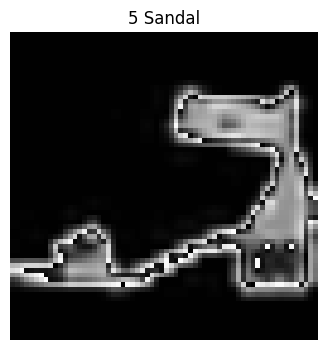

In [22]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize = (4,4))
cols, rows = 1, 1
ids=torch.randint(len(data_test), size = (cols*rows,))

print(ids.item())


image_tensor,label_tensor=ds_processed_test[ids.item()]
image=transforms.ToPILImage()(image_tensor[0,:,:])
image_tensor=image_tensor[None,:,:,:]
label=label_tensor.item()

model=model_best
model.eval()
# model.train()
device='cuda'
X,y = image_tensor.to(device),label_tensor.to(device)
# X=X[None,:,:,:]
pred = model(X)
label_pred=pred.argmax(1).item()
print("label_pred: ",label_pred)
print("label_treu: ", label)

figure.add_subplot(rows, cols, 1)
plt.title(str(label)+" "+classes[label])
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.show()

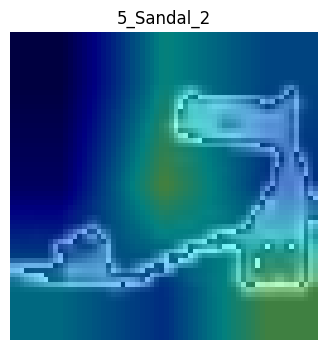

In [23]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import requests
import torchvision
from PIL import Image
import numpy as np

transform_1 = transforms.Compose([
    transforms.Resize((64, 64)), 
])
image_resize=transform_1(image)
image_ts=np.array(image_resize)
image_ts2=image_ts[:,:,None]

image_float_np = np.float32(image_ts2) / 255
input_tensor=X

target_layers=[model.features[-1]]

# CAM model
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

# choose target for analysis
id_target=2
targets = [ClassifierOutputTarget(id_target)]
# targets=[ClassifierOutputTarget(label_pred)] # use predicted value
targets=None # auto find the target with max cam score

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets,aug_smooth=True, eigen_smooth=True)

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
img_vis=Image.fromarray(visualization)

fig=plt.figure(figsize=(4,4))
plt.title(str(label)+"_"+classes[label]+"_"+str(id_target))
plt.axis('off')
plt.imshow(img_vis)
# plt.savefig("../img/"+str(label)+"_"+classes[label]+"_"+str(id_target)+".png")
plt.show()